In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os
from tqdm.notebook import tqdm

xr.set_options(display_style="html");
%load_ext autoreload
%autoreload 2

base_path_project = '/work/bd1179/b309215'
base_path_scratch = '/scratch/b/b309215'

In [2]:
zh_lr_vals = xr.open_dataset(f'{base_path_project}/R02B05VertGrid/zghalf_icon-a_capped_R02B05.nc')['zghalf'].values
zh_hr_vals = xr.open_dataset(f'{base_path_project}/R02B05VertGrid/dei4_NARVALI_2013120100_fg_DOM01_ML_0000_conv_out_R02B05_m2degr_zifc.nc')['z_ifc'].values
print('Print shape of low res vertical ds: ', zh_lr_vals.shape)
print('Print shape of high res vertical ds: ', zh_hr_vals.shape)

exclude_lvls_lr = np.load('../../local_data/exclude_lvls_th.0001_DOM01.npz')['exclude_lvls_lr']
exclude_lvls_hr = np.load('../../local_data/exclude_lvls_th.0001_DOM01.npz')['exclude_lvls']

print('Vlvls to exclude in low res', exclude_lvls_lr)
print('Vlvls to exclude in high res', exclude_lvls_hr)

print('Resulting low res vertical half lvls', zh_lr_vals.shape[0] - len(exclude_lvls_lr))
print('Resulting high res vertical half lvls', zh_hr_vals.shape[0] - len(exclude_lvls_hr))

Print shape of low res vertical ds:  (32, 81920)
Print shape of high res vertical ds:  (76, 81920)
Vlvls to exclude in low res [1 2 3 4 5 6 7 8]
Vlvls to exclude in high res [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Resulting low res vertical half lvls 24
Resulting high res vertical half lvls 59


In [ ]:
from glob import glob

def load_convective_data(path):
    conv_cell_dirs = sorted(glob(path))
    conv_cells = np.zeros((75, 4887488))
    n_timesteps = 0

    files = []
    for ccell_dir in conv_cell_dirs:
        files.extend(sorted([f.path for f in os.scandir(ccell_dir) if '_ccells' in f.name]))

    for file in tqdm(files):
            ds = xr.open_dataset(file)
            conv_cells += ds['ccells'].values.squeeze()
            n_timesteps += len(ds['time'])
    
    return conv_cells, n_timesteps


search_path = f'{base_path_project}/heuer22_convection_parameterization/ProcessedAllVars/**/ConvCells'

conv_cells, n_timesteps = load_convective_data(search_path)

In [3]:
# np.savez('ccell_data', conv_cells=conv_cells, n_timesteps=n_timesteps)
data = np.load('ccell_data.npz')
conv_cells, n_timesteps = data['conv_cells'], data['n_timesteps']

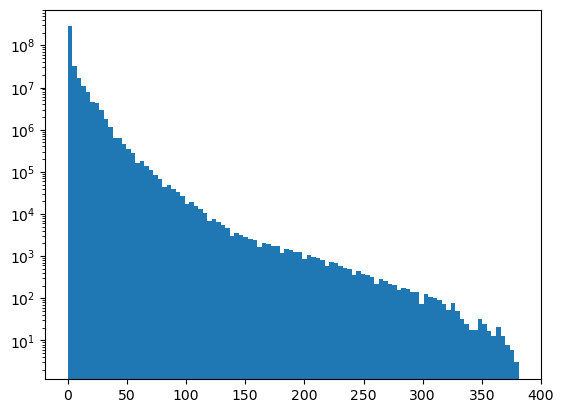

In [4]:
plt.hist(conv_cells.ravel(), bins=100)
plt.yscale('log')
plt.show()

In [5]:
# ds_sample = xr.open_dataset('f'{base_path_scratch}/HErZ-NARVALII/DATA/2013122300/dei4_NARVALI_2013122300_fg_DOM01_ML_0001.nc')
ds_sample = xr.open_dataset(f'{base_path_project}/NARVAL_sample_data/dei4_NARVALI_2013122300_fg_DOM01_ML_0001.nc')
# ds_sample

In [6]:
z_ifc_vals = ds_sample.z_ifc.values 
z_ifc_fl_appr = (z_ifc_vals[1:,:] + z_ifc_vals[:-1,:])/2
z_ifc_fl_appr_mean = np.nanmean(z_ifc_fl_appr, axis=1)
z_ifc_fl_appr_mean_km = z_ifc_fl_appr_mean/1e3
del z_ifc_vals
del z_ifc_fl_appr
print(z_ifc_fl_appr_mean.shape)

(75,)


Levels to exclude: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Heights to exclude: [29.397766 28.220194 27.09695  26.024733 25.000982 24.023943 23.091305
 22.202015 21.354004 20.546001 19.776667 19.044704 18.349009 17.6889
 17.062916 16.47034  15.910757]


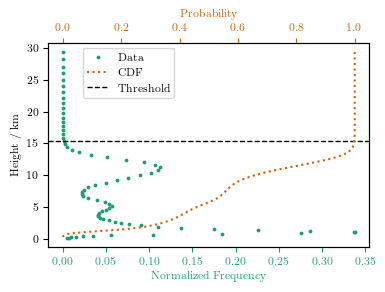

In [8]:
%matplotlib inline
plt.style.use('default')
from convection_param.setup_mpl_tex import setup_mpl_tex, set_size
setup_mpl_tex()
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Dark2.colors)

# halfa4 = 8.3/2
# halfa4_ratio = 6.4/halfa4
# fig, ax = plt.subplots(constrained_layout=True, figsize=(halfa4, 4.8/halfa4_ratio))
# fig, ax = plt.subplots(constrained_layout=True)
fig, ax = plt.subplots(constrained_layout=True, figsize=set_size(width='halfa4'))
conv_lev_sums = np.sum(conv_cells, axis=1)
norm = np.trapz(conv_lev_sums[::-1], x=z_ifc_fl_appr_mean_km[::-1])#, dx=1.0
conv_lev_norm = conv_lev_sums/norm

cummulative_integral = np.empty_like(z_ifc_fl_appr_mean_km)
for i in range(len(cummulative_integral)):
    cummulative_integral[i] = np.trapz(conv_lev_norm[::-1][:i], z_ifc_fl_appr_mean_km[::-1][:i])
cummulative_integral = cummulative_integral[::-1]

threshold = 0.999
exclude_idx = (cummulative_integral > threshold).nonzero()[0]
include_idx = np.array([i for i in range(conv_cells.shape[0]) if i not in exclude_idx])
exclude_lvls = exclude_idx + 1
include_lvls = include_idx + 1
print(f'Levels to exclude: {exclude_lvls}')
print(f'Heights to exclude: {z_ifc_fl_appr_mean_km[exclude_idx]}')
sc1 = ax.scatter(conv_lev_norm, z_ifc_fl_appr_mean_km, s=3, label='Data')
ax2 = ax.twiny()
next(ax2._get_lines.prop_cycler)
# sc2 = ax2.scatter(cummulative_integral, z_ifc_fl_appr_mean_km, s=5, label='Cummulative', color='orange')
sc2, = ax2.plot(cummulative_integral, z_ifc_fl_appr_mean_km, ls=':', label='CDF')#, color='orange')
thr = ax.axhline(z_ifc_fl_appr_mean_km[include_idx[0]], ls='--', color='black', lw=1, label='Threshold')
# ax.scatter(np.mean(conv_cells, axis=1), z_ifc_fl_appr_mean, s=5)
# ax.set_ylim((0,20000))
# ax.set_title(r'$C_L$ - ' + region + ' ' + format_date_str(date))
ax.set_xlabel('Normalized Frequency')#, color='blue')
ax2.set_xlabel('Probability')#, color='orange')
# ax.set_ylabel('Level')
ax.set_ylabel('Height / km')

ax.xaxis.label.set_color(plt.cm.Dark2.colors[0])
ax2.xaxis.label.set_color(plt.cm.Dark2.colors[1])
ax.tick_params(axis='x', colors=plt.cm.Dark2.colors[0])
ax2.tick_params(axis='x', colors=plt.cm.Dark2.colors[1])

scs = [sc1,sc2,thr]
labs = [l.get_label() for l in scs]
# ax.grid()
ax.legend(scs, labs, loc='upper center', bbox_to_anchor=(0.25,1))#(0.2,1))#
# ax.invert_yaxis()

# fig.savefig(f'../../Figures/Pdfplots/convective_cells_profile_halfa4-colored.pdf')
# fig.savefig(f'../../Figures/convective_cells_profile.jpg', dpi=300)
# # fig.savefig(f'../../Figures/convective_cells_profile_sans-serif.pdf')

plt.show()

In [8]:
z_ifc_fl_appr_mean_km

array([29.397766  , 28.220194  , 27.09695   , 26.024733  , 25.000982  ,
       24.023943  , 23.091305  , 22.202015  , 21.354004  , 20.546001  ,
       19.776667  , 19.044704  , 18.349009  , 17.6889    , 17.062916  ,
       16.47034   , 15.910757  , 15.383137  , 14.886336  , 14.420007  ,
       13.994399  , 13.594618  , 13.194861  , 12.795137  , 12.395462  ,
       11.9958315 , 11.596264  , 11.196755  , 10.797331  , 10.397983  ,
        9.998738  ,  9.59961   ,  9.201776  ,  8.810099  ,  8.428222  ,
        8.0559225 ,  7.693078  ,  7.3395243 ,  6.9951553 ,  6.6597753 ,
        6.333316  ,  6.015617  ,  5.706621  ,  5.406151  ,  5.1141768 ,
        4.8305407 ,  4.555196  ,  4.28806   ,  4.0290275 ,  3.7780595 ,
        3.5350616 ,  3.2999904 ,  3.072772  ,  2.8533971 ,  2.6417866 ,
        2.437945  ,  2.2418108 ,  2.053395  ,  1.8726891 ,  1.6997001 ,
        1.534438  ,  1.3769609 ,  1.2273043 ,  1.0855612 ,  0.9518179 ,
        0.82621276,  0.7089199 ,  0.60014945,  0.5001841 ,  0.40

In [9]:
idx = np.ones(len(z_ifc_fl_appr_mean), dtype=bool)
idx[exclude_idx] = False
print('Level differences: ', np.diff(z_ifc_fl_appr_mean[idx][::-1]))

Level differences:  [ 29.65184   46.40735   59.47281   70.80066   81.1326    90.793274
  99.96536  108.770386 117.29291  125.60516  133.74323  141.74316
 149.6565   157.47717  165.26208  172.98901  180.70593  188.41577
 196.13403  203.8418   211.6106   219.37476  227.2185   235.07104
 242.99805  250.96777  259.0327   267.13574  275.34473  283.63623
 291.97412  300.4702   308.9956   317.69922  326.45947  335.37988
 344.36914  353.5537   362.84473  372.29883  381.87695  391.67676
 397.83496  399.12793  399.24414  399.34863  399.4248   399.5078
 399.56738  399.63086  399.67578  399.72363  399.75684  399.78125
 425.60742  466.3291   496.80078 ]


# Plot spatial distribution

In [10]:
from glob import glob
files = sorted(glob('../Processed/**/*.nc', recursive=True))
print(len(files))

0


In [11]:
convsum_arrs = []
for f in tqdm(files):
    convsum_arrs.append(xr.open_dataset(f)['convsum'].values)

0it [00:00, ?it/s]

In [ ]:
print(convsum_arrs[0].shape)
convsum_aggr = np.concatenate(convsum_arrs, axis=0)

In [13]:
# np.savez('convsum_aggr', convsum_aggr=convsum_aggr)
convsum_aggr = np.load('convsum_aggr.npz')['convsum_aggr']

In [14]:
convsum_aggr.shape

(2294, 4596)

(2294, 4596)


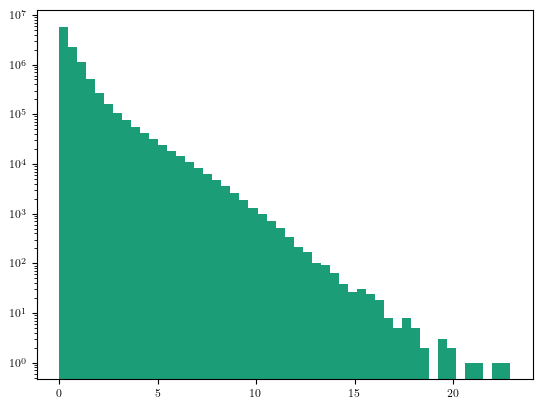

In [15]:
convsum_01 = np.minimum(np.floor(convsum_aggr), 1)
# convsum_01 = convsum_aggr.copy()
# convsum_01 = np.minimum(convsum_aggr, 1)
# convsum_01 = np.floor(convsum_aggr)
print(convsum_01.shape)
plt.figure()
plt.hist(convsum_aggr.flatten(), bins=50)
plt.yscale('log')
plt.show()

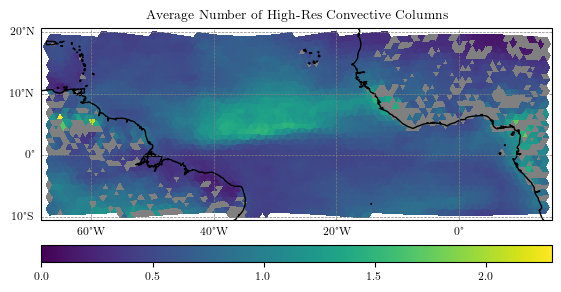

In [19]:
from convection_param.HelperFuncs import plot_icon_tricolor
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)

plt.style.use('default')
from convection_param.setup_mpl_tex import setup_mpl_tex, set_size
setup_mpl_tex()

# sample_ds = xr.open_dataset(files[0])
sample_ds = xr.open_dataset('../../../NARVAL_sample_data/dei4_NARVALI_2013121300_fg_DOM01_ML_0010_conv_out_R02B05_m2degr_vertc.nc')
nan_mask = np.any(np.isnan(sample_ds.temp.values), axis=(0,1))
plot_data = np.mean(convsum_aggr, axis=0)
plot_data[nan_mask] = np.nan

fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()), constrained_layout=True, figsize=set_size(width='textwidth'))

cmap = plt.get_cmap(name='viridis').copy()
cmap.set_bad(color='grey')##4f4c5e')

mapplot = plot_icon_tricolor(ax,
                             sample_ds.clon_bnds.values,
                             sample_ds.clat_bnds.values,
                             plot_data,
                             # np.mean(convsum_01, axis=0),
                             cmap=cmap,
                             vmin=0,
                             zorder=-1)

ax.coastlines()
# ax.gridlines(draw_labels=True, linewidth=0.5, linestyle='--', )#

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.ylocator = mticker.FixedLocator([-10, 0, 10, 20])
# gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
# gl.ylocator = LatitudeLocator()
# gl.xformatter = LongitudeFormatter()
# gl.yformatter = LatitudeFormatter()

ax.set_extent([-68, 15, -8, 16])
fig.colorbar(mapplot, orientation='horizontal', aspect=30, pad=0.02)#, label='Average Number of Convective Columns')

ax.set_rasterization_zorder(0)
ax.set_title('Average Number of High-Res Convective Columns')

# fig.savefig('../../Figures/AverageConvectiveCells_viridis_masked.jpg', dpi=300, bbox_inches='tight')
# fig.savefig('../../Figures/Pdfplots/AverageConvectiveCells_viridis_masked.pdf', dpi=600, bbox_inches='tight')

plt.show()

In [20]:
print(fig.get_figwidth())
print(fig.get_figheight())

5.499212598425197
4.124409448818898
